In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from autograd import elementwise_grad
import autograd.numpy as np
import scipy

In [2]:
betas = np.random.beta(5,1,size=100)

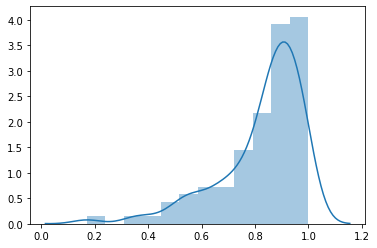

In [3]:
sns.distplot(betas)

In [4]:
def sal(par,y):
    return par[0]+par[1]*np.sinh(par[2]*np.arcsinh(y) + par[3])

In [5]:
sal([1,1,1,1],betas)

array([3.65229299, 3.44471574, 4.06316834, 4.10172807, 3.86187779,
       3.28058753, 3.58301671, 2.85302877, 3.13413408, 4.09446164,
       4.14631326, 2.99094785, 4.05553473, 3.93983919, 2.77085333,
       3.84403684, 2.45709882, 3.5335253 , 4.03716493, 3.86251294,
       3.70741875, 4.07247594, 4.07345002, 4.04998594, 4.2028295 ,
       3.79010234, 3.09539868, 3.78296961, 3.89193155, 3.94853439,
       3.9831398 , 4.07746639, 4.11413437, 3.88966343, 3.98272433,
       3.25660459, 4.05430576, 3.85798845, 3.8475585 , 3.57021096,
       4.03580597, 3.99124359, 3.92827453, 4.19476396, 3.91583218,
       3.40790646, 3.8693401 , 4.16973163, 4.07242398, 4.10902811,
       4.16170561, 3.44634081, 3.97406038, 3.9062059 , 3.20481257,
       4.19613917, 4.03835122, 3.89879835, 3.75056879, 4.01356418,
       3.85035716, 3.20950046, 4.0742702 , 3.88663864, 4.17266279,
       3.80326873, 3.50865842, 3.27260591, 4.0454946 , 4.18224171,
       3.99401696, 3.96034515, 4.18158972, 3.68787736, 3.82043

In [11]:
d_sal = elementwise_grad(sal)

In [7]:
d_sal

<function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f(*args, **kwargs)>

In [15]:
d_sal([1,1,1,1],betas)

TypeError: Can't differentiate w.r.t. type <class 'int'>